https://www.tensorflow.org/tutorials/keras/basic_classification

https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py


In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [3]:
tr_im = np.loadtxt("reals.dat")

In [4]:
tr_im.shape

(20000, 4000)

In [5]:
nrow,ncol = 80,50

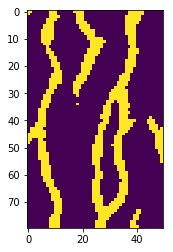

In [6]:
plt.imshow(tr_im[0,:].reshape((nrow,ncol)))

In [7]:
npar = 100 #number of standard normal deviates to feed to generator input

In [8]:
tr_im.max()

1.0

In [9]:
#opt = tf.train.AdamOptimizer(learning_rate=0.0005,beta1=0.5)
opt = Adam(lr=0.0005,beta_1=0.5)

In [13]:
# generator = keras.Sequential()
# generator.add(keras.layers.Dense(256, input_dim=npar, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
# generator.add(keras.layers.LeakyReLU(0.2))
# generator.add(keras.layers.Dense(512))
# generator.add(keras.layers.LeakyReLU(0.2))
# generator.add(keras.layers.Dense(1024))
# generator.add(keras.layers.LeakyReLU(0.2))
# generator.add(keras.layers.Dense(784, activation="sigmoid"))
# generator.compile(loss='binary_crossentropy', optimizer=opt)
# generator.summary()

In [14]:
# discriminator = keras.Sequential()
# discriminator.add(keras.layers.Reshape((28,28,1),input_shape=(784,)))
# discriminator.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="same")
# discriminator.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation=tf.nn.relu))
# discriminator.add(keras.layers.MaxPool2D(pool_size=(2,2)))
# discriminator.add(keras.layers.Dropout(0.25))
# discriminator.add(keras.layers.Flatten())
# discriminator.add(keras.layers.Dense(128,activation=tf.nn.relu))
# discriminator.add(keras.layers.Dropout(0.5))
# discriminator.add(keras.layers.Dense(1,activation="sigmoid"))

# discriminator.summary()
# discriminator = keras.Sequential()
# discriminator.add(keras.layers.Dense(1024, input_dim=784, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
# discriminator.add(keras.layers.LeakyReLU(0.2))
# discriminator.add(keras.layers.Dropout(0.3))
# discriminator.add(keras.layers.Dense(512))
# discriminator.add(keras.layers.LeakyReLU(0.2))
# discriminator.add(keras.layers.Dropout(0.3))
# discriminator.add(keras.layers.Dense(256))
# discriminator.add(keras.layers.LeakyReLU(0.2))
# discriminator.add(keras.layers.Dropout(0.3))
# discriminator.add(keras.layers.Dense(1, activation='sigmoid'))
#discriminator.compile(loss='binary_crossentropy', optimizer=opt)
#discriminator.summary()

In [10]:
tr_im.max(),tr_im.min()

(1.0, 0.0)

In [52]:
generator = Sequential()
generator.add(Dense(100*8*5, input_dim=npar, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((100, 8, 5)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(2, 2), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(5, 5)))
generator.add(Conv2D(1, kernel_size=(2, 2), padding='same', activation='softmax'))
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 4000)              404000    
_________________________________________________________________
leaky_re_lu_75 (LeakyReLU)   (None, 4000)              0         
_________________________________________________________________
reshape_37 (Reshape)         (None, 100, 8, 5)         0         
_________________________________________________________________
up_sampling2d_69 (UpSampling (None, 100, 16, 10)       0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 64, 16, 10)        25664     
_________________________________________________________________
leaky_re_lu_76 (LeakyReLU)   (None, 64, 16, 10)        0         
_________________________________________________________________
up_sampling2d_70 (UpSampling (None, 64, 80, 50)        0         
__________

In [59]:
# Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 80, 50), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=opt)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 128, 40, 25)       3328      
_________________________________________________________________
leaky_re_lu_79 (LeakyReLU)   (None, 128, 40, 25)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 40, 25)       0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 128, 20, 13)       409728    
_________________________________________________________________
leaky_re_lu_80 (LeakyReLU)   (None, 128, 20, 13)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 128, 20, 13)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 33280)             0         
__________

In [54]:
discriminator.trainable = False
gi = Input(shape=(npar,))
x = generator(gi)
go = discriminator(x)
gan = Model(inputs=gi,outputs=go)
gan.compile(loss="binary_crossentropy",optimizer=opt)

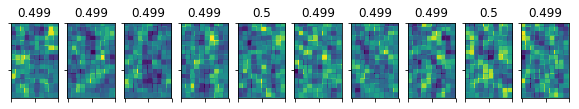

In [56]:

def plot_gen():
    fig, axes = plt.subplots(nrows=1,ncols=10,figsize = (10,10))
    plot_noise = np.random.randn(10,npar) 
    vecs = generator.predict(plot_noise)#.reshape(10,28,28)
    isreal = discriminator.predict(vecs)
    #print(isreal.shape)
    for ax,vec,real in zip(axes.flatten(),vecs.reshape(10,nrow,ncol),isreal.flatten()):
        ax.imshow(vec)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title("{0:1.3G}".format(real))
plot_gen()
#generator.save("test.h5")
o_d = "gen_models"
if os.path.exists(o_d):
    shutil.rmtree(o_d)
os.mkdir(o_d)

156


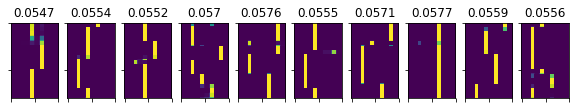

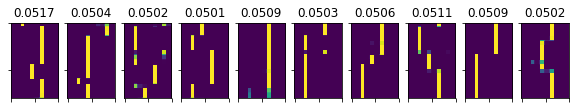

KeyboardInterrupt: 

In [58]:
batch_size = 128
batch_count = int(tr_im.shape[0] / batch_size)
print(batch_count)
plot_gen()
plt.show()
for e in range(1,100):
    for bc in range(batch_count):
        noise = np.random.randn(batch_size,npar)
        tr_im_batch = tr_im[np.random.randint(0,tr_im.shape[0],size=batch_size)]
        gen_im = generator.predict(noise)
        tr_im_batch = np.resize(tr_im_batch,(batch_size,1,nrow,ncol))
        #print(gen_im.shape,tr_im_batch.shape)
        tr_im_batch = np.concatenate([tr_im_batch,gen_im])
        #noisy labels...
        tr_im_lab = np.zeros(tr_im_batch.shape[0])
        tr_im_lab[:batch_size] = np.random.uniform(0.9,1.0,size=batch_size)
        tr_im_lab[batch_size:] = np.random.uniform(0.0,0.1,size=batch_size)
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(tr_im_batch,tr_im_lab)
        noise = np.random.randn(batch_size,npar)
        tr_img_lab = np.ones(batch_size)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise,tr_img_lab)
        print(bc,gloss,dloss,end="\r")
    if e % 1 == 0:
        print(e,gloss,dloss)
        plot_gen()
        plt.show()
        generator.save(os.path.join(o_d,"gen_{0}.h5").format(e))
        
    